In [1]:
import pandas as pd
import pickle
import sys
sys.path.append('/Users/jarvis/Desktop/CODE/sadrat/')

from scrapers.helpers import Preprocessing

In [3]:
df = pd.read_csv("/Users/jarvis/Desktop/CODE/sadrat/sample/medications_dot_com_data.csv")

In [4]:
df.head()

,id,drugname,comment
0,0,levaquin,ive been allergic to many antibiotics since I ...
1,1,levaquin,Was prescribed leviquin for sinus. Took dose ...
2,2,levaquin,Been reading the blog - thank God. Thank God ...
3,3,levaquin,1/14/2012. I was given Levaquin and two steroi...
4,4,levaquin,today was my 3rd day of taking levaquin. i suf...


In [5]:
#looking at the comments to have an intuition for labelling functions
#PLEASE NOTE THAT I MADE A SILLY MISTAKE WHILE NAMING MY COLUMN IN THE DATASET, THERE'S A SPACE BEFORE 
# "comment" AND "drugname". WRITE IT AS " comment" and " drugname". 
df[" comment"][100]

'During the last 1 1/2 years, I have suffered severe hearing loss, first my right ear and now my left.  I have regained perhaps 50-60% hearing in my right ear but a few days ago the same symptons reappeared and within 5 days I have lost all hearing in my\xa0... more »During the last 1 1/2 years, I have suffered severe hearing loss, first my right ear and now my left.  I have regained perhaps 50-60% hearing in my right ear but a few days ago the same symptons reappeared and within 5 days I have lost all hearing in my left ear!\nI am currently taking prednisone for 7 days.\nHas anyone else experienced hearing loss which they attribute to the use of warfarin (coumaden?)  I am desperate for information that might lead me to some sort of enlightenment I could build on.\nKen'

### Getting the dictionary of drugs and their known side effects scraped from drugs.com website.

In [6]:
with open("/Users/jarvis/Desktop/CODE/sadrat/datasets/drug_adr", "rb") as file:
    drugs = pickle.load(file)
file.close()

# Labelling Functions

In [4]:
from snorkel.labeling import labeling_function

## LF1: Sentiment Analysis
The ADRs are usually written with a negative tone so starting with sentiment analysis as the first labelling function is a good start : )

In [1]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob

In [35]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache using fc-list. This may take a moment.


In [26]:
@preprocessor(memoize=True)
# type(x) - pandas Series
def textblob_sentiment(x):
    scores = TextBlob(x[" comment"])
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [33]:
comment_polarities = [textblob_sentiment(x).polarity for _, x in df.iterrows()]
comment_subjectivities = [textblob_sentiment(x).subjectivity for _, x in df.iterrows()]

#### NOTE:
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. <br>
**Hence a probable ADR must have low polarity and high subjectivity**

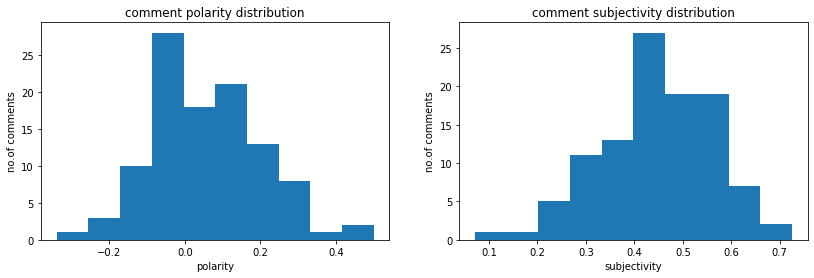

In [52]:
# plotting the data
plt.subplot(1,2,1)
plt.hist(comment_polarities, bins=10)
plt.title("comment polarity distribution")
plt.xlabel("polarity")
plt.ylabel("no.of comments")

plt.subplots_adjust(hspace=1, left=0.225, right=2, wspace=0.2)

plt.subplot(1,2,2)
plt.hist(comment_subjectivities, bins=10)
plt.title("comment subjectivity distribution")
plt.xlabel("subjectivity")
plt.ylabel("no.of comments")
plt.show()

In [58]:
# Create LF from sentiment analysis
# 1 means postitive ADR 0 means not an ADR
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return 0 if x.polarity >=0.4 else 1

In [59]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return 1 if x.subjectivity >= 0.5 else 0

## LF2: Based on Known ADRs - Distant Supervision
Return 1 if ADR for the given drug is already known else return 0.<br>
Use the preprocessing function from helpers.py

In [ ]:
## @labeling_function()
def distant_supervision(x):
    """
    @params: type(x): str
    return 1 if ADR is a known ADR and 0 if not known ADR
    """
    # Preprocess the string
    p = Preprocessing()
    clean_text = p.custom_preprocessor(x)
    for word in clean_text:
        if word.capitalize() in drugs.keys():
            known_adr = drugs[word]  # type(known_adr) should be list
        else:
            continue
    if len(known_adr) != 0:
        # check whether known ADRs are present
        for x in clean_text:
            
    else:
        return 0
    

In [11]:
for x in drugs.keys():
    print(x,drugs[x])
    break

Abilify ['severe agitation, distress, or restless feeling', 'twitching or uncontrollable movements of your eyes, lips, tongue, face, arms, or legs', 'mask-like appearance of the face, trouble swallowing, problems with speech', 'seizure (convulsions)', 'thoughts about suicide or hurting yourself', 'severe nervous system reaction--very stiff (rigid) muscles, high fever, sweating, confusion, fast or uneven heartbeats, tremors, feeling like you might pass out', 'low blood cell counts--sudden weakness or ill feeling, fever, chills, sore throat, swollen gums, painful mouth sores, red or swollen gums, skin sores, cold or flu symptoms, cough, trouble breathing or', 'high blood sugar--increased thirst, increased urination, hunger, dry mouth, fruity breath odor, drowsiness, dry skin, weight loss']


## LF3: Clustering with TF.IDF Vectorization and KNN 
In this LF(LF3), We implement non-hierarchial clustering with two or three clusters, we then have to use another LF(say LF2) to determine the cluster that has higher number of positive ADRs and the one with the lower/lowest number of positive ADRs.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [3]:
df = pd.read_csv("/Users/jarvis/Desktop/CODE/sadrat/sample/medications_dot_com_data.csv")

In [17]:
def clustering(x):
    """
    @params: type(x): list of raw documents(list of strings)
    """
    if len(x) == 0:
        raise Exception("Size of input list should be greater than 0")
    
    K = 3  # value of K in KNN
    
    # Preprocess documents(document is just another way of saying a sentence)
    p = Preprocessing()
    clean_corpus = list()
    for doc in x:
        if(type(doc) != str):
            raise Exception("The input list must contain string datatype")
        clean_doc = p.simple_preprocessor_string(doc)
        
        #case when after preprocessing nothing remains in the string (useless document)
        if clean_doc == "":
            continue
        else:
            clean_corpus.append(clean_doc)
        
#     print(clean_corpus[1], type(clean_corpus[1]))
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(clean_corpus)
    model = KMeans(n_clusters=K, init='k-means++')
    model.fit(X)
    
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(K):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(terms[ind], end=" ")
        print("\n")


In [18]:
# Driver Code
raw_corpus = list()
for _, x in df.iterrows():
    raw_corpus.append(x[" comment"])
clustering(raw_corpus)

Top terms per cluster:
Cluster 0:
watches moncler oris tiffany collection edition jubile vintage iwc known 

Cluster 1:
day days pain mg taking like side started time take 

Cluster 2:
questran months years drug high diarrhea given would doctor ve 



In [ ]:
# Use the KNN model as labelling Function
# TODO:
# Identify which cluster represents an ADR better (Requires another LF)